# Delete first two lines if first time opening data folder

In [1]:
import os

def rm_first_two_lines_of_each_file_in_folder(path):
    folder_path = path
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            with open(file_path, 'r') as f:
                lines = f.readlines()
            # Skip the first 2 lines
            lines = lines[2:]
            with open(file_path, 'w') as f:
                f.writelines(lines)

# rm_first_two_lines_of_each_file_in_folder(path="/home/frankwoods/Desktop/lassie/data/mhxx_raw_data")


# Convert every csv to pandas data frame format

In [2]:


import os
import pandas as pd

df_list = []
for filename in os.listdir("/home/frankwoods/Desktop/lassie/data/ws23_raw_data"):
    # creates dataframe holding entire csv
    df = pd.read_csv(f"/home/frankwoods/Desktop/lassie/data/ws23_raw_data/{filename}")
    # takes just the two important columns
    df = df[['toeforce_y', 'toe_position_y']]
    df.columns = ["resistance", "depth"] # rename columns
    df_list.append(df)
print(f"example: {df_list[0]}")



example:        resistance     depth
0       -0.683593 -0.188659
1       -0.683593 -0.188659
2       -0.683593 -0.188659
3       -0.683593 -0.188659
4       -0.683593 -0.188659
...           ...       ...
11599   -1.929471 -0.158198
11600   -1.929471 -0.158198
11601   -1.929471 -0.158198
11602   -1.929471 -0.158198
11603   -1.929471 -0.158198

[11604 rows x 2 columns]


# Initial Data Visualization and Summary

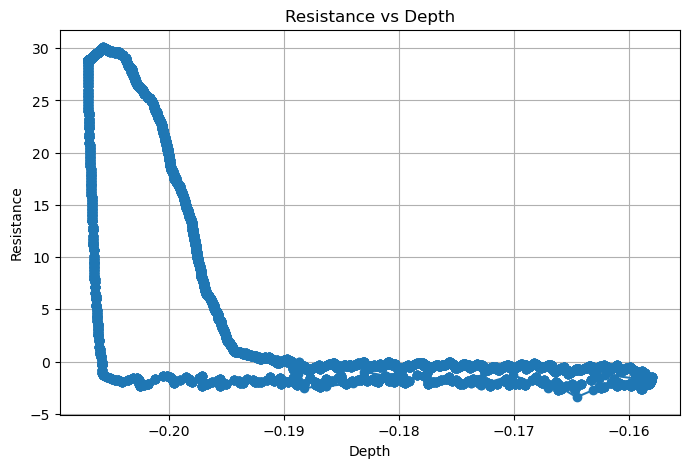

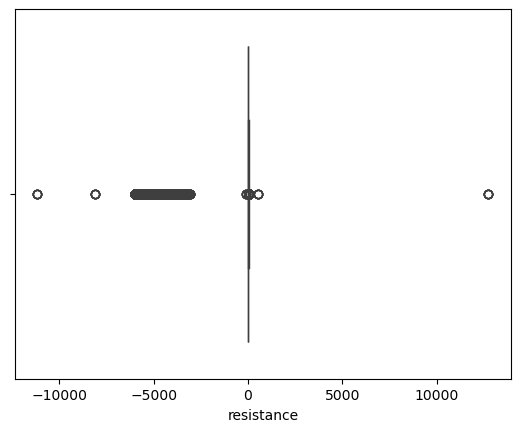

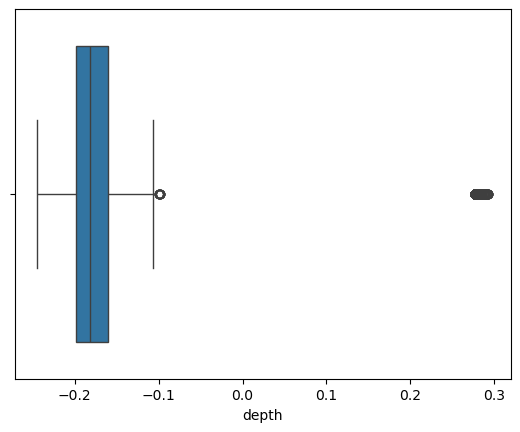

In [3]:


import seaborn as sns
import matplotlib.pyplot as plt

# ---- plot an example graph ----
# Assume you have a DataFrame df with columns 'depth' and 'resistance'
def visualize_data(df_list, graph=False, save_all_graphs=False, box_plots=False, histograms=False, graph_i=0):
    if graph:
        plt.figure(figsize=(8,5))         # Optional: set figure size
        plt.plot(df_list[graph_i]['depth'], df_list[graph_i]['resistance'], marker='o', linestyle='-')
        plt.xlabel('Depth')
        plt.ylabel('Resistance')
        plt.title('Resistance vs Depth')
        plt.grid(True)                    
        plt.show()
    
    if save_all_graphs:
        for i, df in enumerate(df_list):
            plt.figure(figsize=(8,5))         # Optional: set figure size
            plt.plot(df['depth'], df['resistance'], marker='o', linestyle='-')
            plt.xlabel('Depth (m)')
            plt.ylabel('Resistance (N)')
            plt.title('Resistance vs Depth')
            plt.savefig(f"data/ws23_raw_data_visual/depth_res_{i}")
            plt.close()

    df_combined_row_wise = pd.concat(df_list, axis=0)
    if box_plots:
        # ---- resistance ----
        sns.boxplot(x=df_combined_row_wise['resistance'])
        plt.show()
        resistance_series = df_combined_row_wise['resistance']
        # ---- depth ----
        sns.boxplot(x=df_combined_row_wise['depth'])
        plt.show()
    if histograms:
        plt.hist(df_combined_row_wise["resistance"], bins=30, density=True)
        plt.title("Resistance Histogram")
        plt.show()

        plt.hist(df_combined_row_wise["depth"], bins=30, density=True)
        plt.title("Depth Histogram")
        plt.show()


visualize_data(df_list, graph=True, save_all_graphs=False, box_plots=True)

# Inverse Depth, Remove Data of Before Leg Hits Ground, Remove Data of After Leg Hits Ground

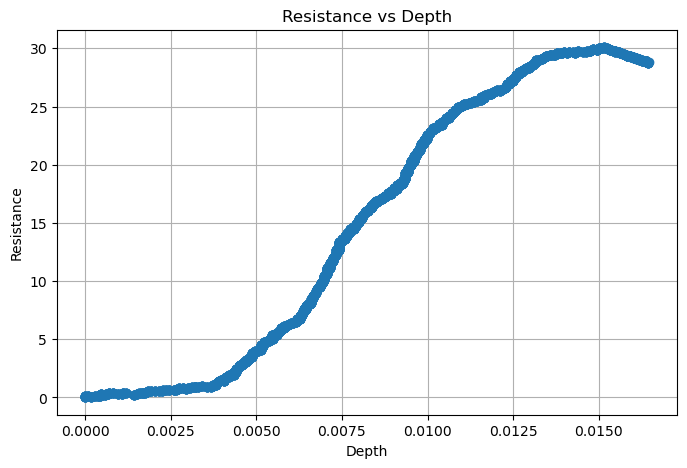

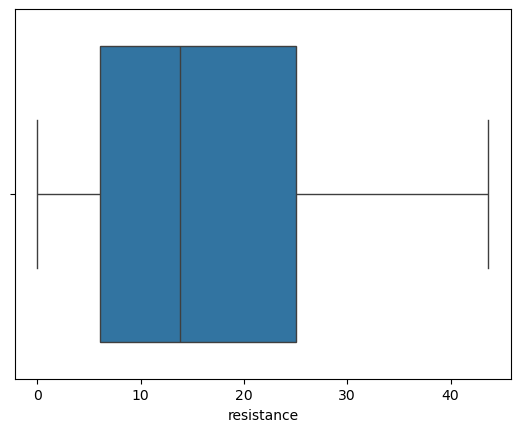

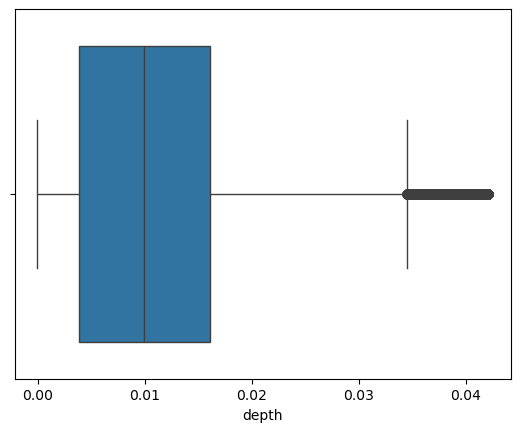

In [4]:
# default normalization is non-robust to outliers
from sklearn import preprocessing
from tqdm import tqdm
import numpy as np

res_count = 0
depth_count = 0
res_total = 0
depth_total = 0
for i in range(len(df_list)):
    res_condition = df_list[i]["resistance"] > 0
    depth_condition = df_list[i]["depth"] > 0
    res_count += res_condition.sum()
    depth_count += depth_condition.sum()
    res_total += df_list[i]["resistance"].size
    depth_total += df_list[i]["depth"].size
# print(f"resistance count > 0: {res_count} / {res_total}")
# print(f"depth count > 0: {depth_count} / {depth_total}")

# negate depth bc all init depth values are negative
def clean_depth(df_i):
    df_i["depth"] = -df_i["depth"]
    # all depth values must be above 0, noise otherwise
    df_i = df_i[df_i["depth"] > 0]
    return df_i

# get the data starting from leg hitting ground, to the max depth
def clean_resistance(df_i):
    end_idx = df_i[df_i["depth"] == df_i["depth"].max()].index[0]
    start_idx = 0
    for i in range(end_idx + 1):
        if df_i["resistance"][i] < 0 and start_idx != end_idx:
            start_idx = i + 1
    return df_i.iloc[start_idx : end_idx + 1]

df_list = df_list[:65] + df_list[67:] # removing bad data entry
for i in range(len(df_list)):
    df_i = df_list[i]
    df_i = clean_depth(df_i)
    df_i = clean_resistance(df_i)
    # start every graph at 0
    df_i["depth"] = df_i["depth"] - df_i["depth"].iloc[0]
    df_list[i] = df_i

visualize_data(df_list, True, False, True)

# Convert every depth-resistance csv into a pandas dataframe

global min depht: 0.0016654878854751032


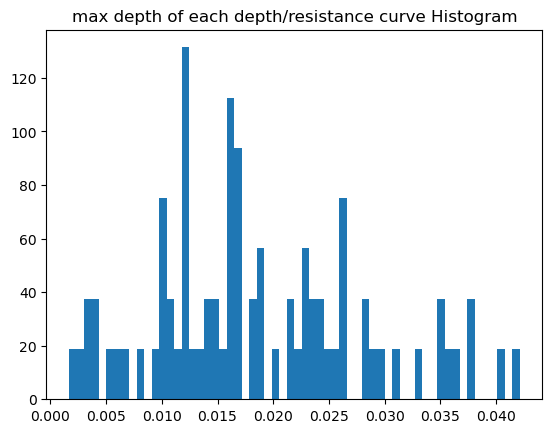

In [5]:

# depth_global_max = find_global_min_max(df_list)
min_of_all_df_depths = float('inf')
df_ends_list = []
for df in df_list:
    df_max_depth = df["depth"].max()
    if min_of_all_df_depths > df_max_depth:
        min_of_all_df_depths = df_max_depth
    df_ends_list.append(df_max_depth)
print(f"global min depht: {min_of_all_df_depths}")

plt.hist(df_ends_list, bins=60, density=True)
plt.title("max depth of each depth/resistance curve Histogram")
plt.show()


# Interpolation
Used to estimate values between data points to create a uniform vector of data intervals for each data object.

In [6]:
# TODO interpolation requires ascending x-axis coords ... depth is not so will need to fix this if want to use
# def interpolate(df_list, num_points):
#     interp_df_list = []
#     i = 0
#     for df in df_list:
#         is_ascending = np.all(np.diff(df["depth"]) >= 0)
#         if not is_ascending:
#             i += 1
#             print(f"df {i} is not ascending")
#             continue
#         x_intervals = np.linspace(0, len(df["depth"]) - 1, num_points) # 100 points between 0 and trunc_level
#         y_new = np.interp(x_intervals, df["depth"], df["resistance"])
#         new_df = pd.DataFrame({'depth': x_intervals, 'resistance': y_new})
#         interp_df_list.append(new_df)
#         i += 1
#     return interp_df_list

# interpolated_df_list = interpolate(df_list, 100)
# print("Before interpolation")
# visualize_data(df_list, graph=True, graph_i=16)
# print("After interpolation")
# visualize_data(interpolated_df_list, graph=True, graph_i=16)

# Final Visualization

In [ ]:
# visualize_data(trunc_df_list, True, False, True)
def save_data_csv(final_df_list, save: bool):
    if save:
        for i in range(len(final_df_list)):
            final_df_list[i].to_csv(f"/home/frankwoods/Desktop/lassie/data/ws23_processed_data/resistance_depth_{i}.csv")

save_data_csv(df_list, save=False)